In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import ttest_rel

from div_fgan_data import scene_data, yeast_data

In [2]:
def collect_stats(data, pval=False, **kwargs):
    """Collect statistics about model """
    model_data = dict()

    soft_base = data["nn-soft 32-8 fgan 0"]
    hard_base = data["nn-hard 32-8 fgan 0"]

    for model, values in data.items():
        model_stats = {
            stat: func(values)
            for stat, func in kwargs.items()    
        }
        if pval:
            comp_data = soft_base if "soft" in model else hard_base
            pvalue = ttest_rel(comp_data, values, alternative="two-sided")
            model_stats["pval"] = pvalue.pvalue
            
        model_data[model] = model_stats

    return model_data

In [3]:
stat_collect = dict(mean=np.mean, std=np.std)
scene_exp_scores = collect_stats(scene_data["exp"], pval=True, **stat_collect)
scene_map_scores = collect_stats(scene_data["map"], pval=True, **stat_collect)
del scene_exp_scores["logging"]
del scene_exp_scores["logger-og"]
del scene_map_scores["logging"]
del scene_map_scores["logger-og"]


yeast_exp_scores = collect_stats(yeast_data["exp"], pval=True, **stat_collect)
yeast_map_scores = collect_stats(yeast_data["map"], pval=True, **stat_collect)

del yeast_exp_scores["logging"]
del yeast_exp_scores["logger-og"]
del yeast_map_scores["logging"]
del yeast_map_scores["logger-og"]

In [4]:
class Model():
    def __init__(self, name, stats):
        nn_type, _, _, self.n_steps = name.split()
        self.n_steps = int(self.n_steps)

        nn_type = str.capitalize(nn_type[3:])
        self.is_hard = nn_type == "Hard"
        self.type = "NN " + nn_type  
        self.stats = stats
        

    def __str__(self):
        return f"{self.type} fgan {self.n_steps}"

    def __repr__(self):
        return str(self)

    def get_stat(self, name):
        return self.stats[name]

In [5]:
def to_model(data):
    return [
        Model(model, stats)
        for model, stats in data.items()
    ]

In [6]:
def get_plot_data(models):
    x = []
    y = []
    err = []
    pval = []
    
    for model in models:
        x.append(model.n_steps)
        y.append(model.get_stat("mean"))
        err.append(model.get_stat("std"))
        pval.append(model.get_stat("pval"))

    return np.array(x), np.array(y), np.array(err), np.array(pval)
        

In [7]:
scene_map_scores = to_model(scene_map_scores)
scene_exp_scores = to_model(scene_exp_scores)

yeast_map_scores = to_model(yeast_map_scores)
yeast_exp_scores = to_model(yeast_exp_scores)

In [8]:
size = 20
params = {'axes.labelsize': size * 0.75,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': size*0.75}
plt.rcParams.update(params)

In [9]:
def parse_and_add_plot(ax, model_data, color, model_type):
    x, y, err, pvals = get_plot_data(model_data)
    signf_mask = pvals < alpha
    marker_settings_notsig = dict(color="white", linestyle="", markeredgecolor=color, ms=8.5, marker="o")
    ax.plot(x, y, marker="", color=color)
    ax.plot(x[~signf_mask], y[~signf_mask], **marker_settings_notsig)
    ax.plot(x[signf_mask], y[signf_mask], marker="o", label=f"NN {model_type}", color=color, linestyle="", ms=8.5)
    ax.fill_between(x=x,
                     y1=y - err,
                     y2=y + err,
                     alpha=0.25,
                     color=color
                     )

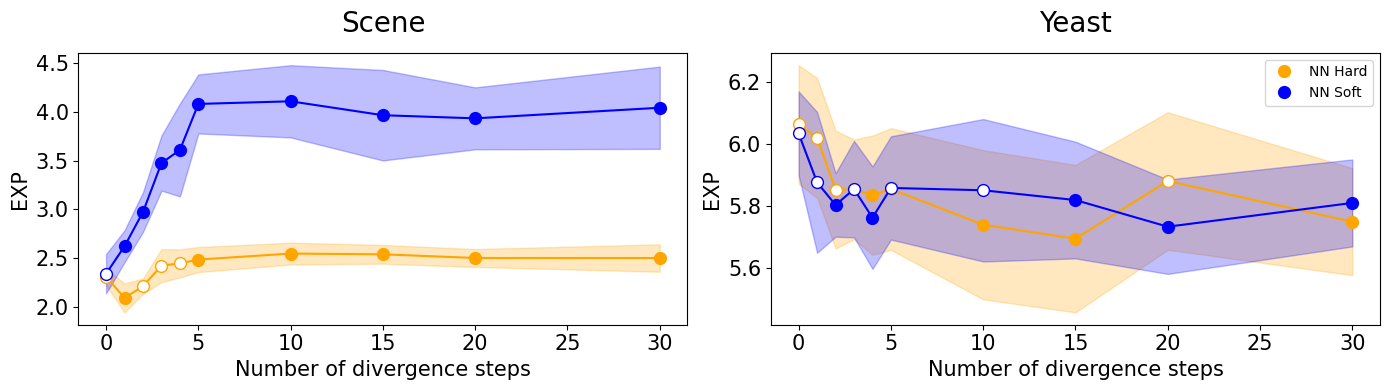

In [10]:
subplot_conf = dict(ncols=2, nrows=1, figsize=(14, 4))
fig, axes = plt.subplots(**subplot_conf)
alpha = 0.05


############################## Scene
models_scene_exp = list(filter(lambda x: x.is_hard, scene_exp_scores))
parse_and_add_plot(
    ax=axes[0],
    model_data=models_scene_exp,
    color="orange",
    model_type="Hard"
)

models_scene_exp = list(filter(lambda x: not x.is_hard, scene_exp_scores))
parse_and_add_plot(
    ax=axes[0],
    model_data=models_scene_exp,
    color="blue",
    model_type="Soft"
)
axes[0].set_xlabel("Number of divergence steps")
axes[0].set_ylabel("EXP")
axes[0].set_title("Scene")


############################## Yeast
models_yeast_exp = list(filter(lambda x: x.is_hard, yeast_exp_scores))
parse_and_add_plot(
    ax=axes[1],
    model_data=models_yeast_exp,
    color="orange",
    model_type="Hard"
)

models_yeast_exp = list(filter(lambda x: not x.is_hard, yeast_exp_scores))
parse_and_add_plot(
    ax=axes[1],
    model_data=models_yeast_exp,
    color="blue",
    model_type="Soft"
)
axes[1].set_xlabel("Number of divergence steps")
axes[1].set_ylabel("EXP")
axes[1].set_title("Yeast")
axes[1].legend(fontsize=size * .5)

axes[0].plot()
plt.tight_layout()
plt.savefig(f"fgan_steps_exp.pdf", bbox_inches="tight")
plt.show()

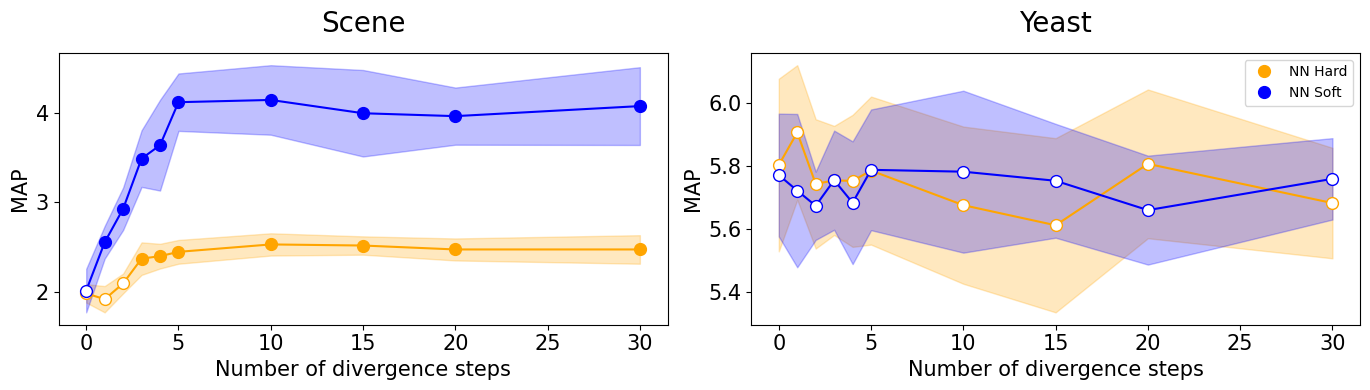

In [11]:

fig, axes = plt.subplots(**subplot_conf)

############################## Scene
models_scene_exp = list(filter(lambda x: x.is_hard, scene_map_scores))
parse_and_add_plot(
    ax=axes[0],
    model_data=models_scene_exp,
    color="orange",
    model_type="Hard"
)

models_scene_exp = list(filter(lambda x: not x.is_hard, scene_map_scores))
parse_and_add_plot(
    ax=axes[0],
    model_data=models_scene_exp,
    color="blue",
    model_type="Soft"
)
axes[0].set_xlabel("Number of divergence steps")
axes[0].set_ylabel("MAP")
axes[0].set_title("Scene")


############################## Yeast
models_yeast_exp = list(filter(lambda x: x.is_hard, yeast_map_scores))
parse_and_add_plot(
    ax=axes[1],
    model_data=models_yeast_exp,
    color="orange",
    model_type="Hard"
)

models_yeast_exp = list(filter(lambda x: not x.is_hard, yeast_map_scores))
parse_and_add_plot(
    ax=axes[1],
    model_data=models_yeast_exp,
    color="blue",
    model_type="Soft"
)
axes[1].set_xlabel("Number of divergence steps")
axes[1].set_ylabel("MAP")
axes[1].set_title("Yeast")
axes[1].legend(fontsize=size * .5)


axes[0].plot()
plt.tight_layout()
plt.savefig(f"fgan_steps_map.pdf", bbox_inches="tight")
plt.show()

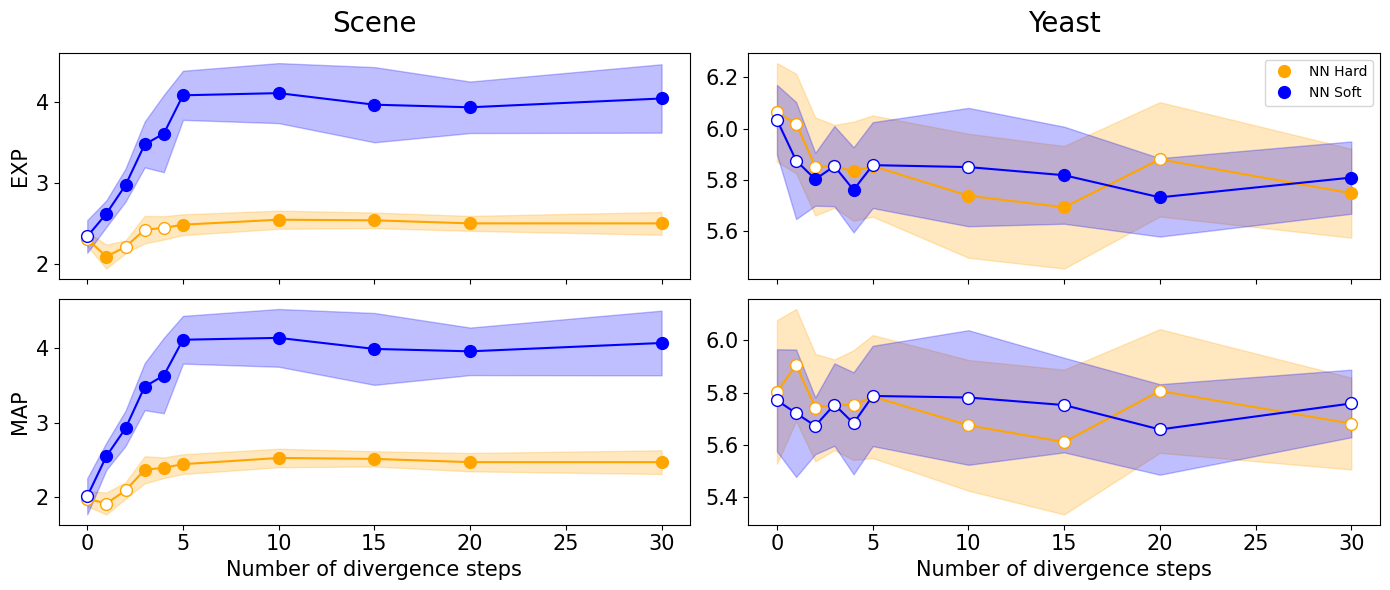

In [13]:
subplot_conf = dict(ncols=2, nrows=2, figsize=(14, 6), sharex=True)
fig, axes = plt.subplots(**subplot_conf)
alpha = 0.05

#### EXP
############################## Scene
models_scene_exp = list(filter(lambda x: x.is_hard, scene_exp_scores))
parse_and_add_plot(
    ax=axes[0, 0],
    model_data=models_scene_exp,
    color="orange",
    model_type="Hard"
)

models_scene_exp = list(filter(lambda x: not x.is_hard, scene_exp_scores))
parse_and_add_plot(
    ax=axes[0, 0],
    model_data=models_scene_exp,
    color="blue",
    model_type="Soft"
)
axes[0, 0].set_ylabel("EXP")
axes[0, 0].set_title("Scene")


############################## Yeast
models_yeast_exp = list(filter(lambda x: x.is_hard, yeast_exp_scores))
parse_and_add_plot(
    ax=axes[0, 1],
    model_data=models_yeast_exp,
    color="orange",
    model_type="Hard"
)

models_yeast_exp = list(filter(lambda x: not x.is_hard, yeast_exp_scores))
parse_and_add_plot(
    ax=axes[0, 1],
    model_data=models_yeast_exp,
    color="blue",
    model_type="Soft"
)
axes[0, 1].set_title("Yeast")
axes[0, 1].legend(fontsize=size * .5)

### MAP
############################## Scene
models_scene_exp = list(filter(lambda x: x.is_hard, scene_map_scores))
parse_and_add_plot(
    ax=axes[1, 0],
    model_data=models_scene_exp,
    color="orange",
    model_type="Hard"
)

models_scene_exp = list(filter(lambda x: not x.is_hard, scene_map_scores))
parse_and_add_plot(
    ax=axes[1, 0],
    model_data=models_scene_exp,
    color="blue",
    model_type="Soft"
)
axes[1, 0].set_xlabel("Number of divergence steps")
axes[1, 0].set_ylabel("MAP")


############################## Yeast
models_yeast_exp = list(filter(lambda x: x.is_hard, yeast_map_scores))
parse_and_add_plot(
    ax=axes[1, 1],
    model_data=models_yeast_exp,
    color="orange",
    model_type="Hard"
)

models_yeast_exp = list(filter(lambda x: not x.is_hard, yeast_map_scores))
parse_and_add_plot(
    ax=axes[1, 1],
    model_data=models_yeast_exp,
    color="blue",
    model_type="Soft"
)
axes[1, 1].set_xlabel("Number of divergence steps")


axes[0, 0].plot()
plt.tight_layout()
plt.savefig(f"fgan_steps_all.pdf", bbox_inches="tight")
plt.show()